# Random Forest Regressor

- **랜덤포레스트(Random Forest)** 는 **Bagging**기반의 앙상블 기법중 하나로, **Boostrap Sampling**을 통해 여러개의 의사결정나무(베이스모델)를 생성한 후에 다수결 또는 평균에 따라 출력변수를 예측함
    - **Bootstrap Sampling** : 학습 데이터로부터 원하는 크기의 샘플을 복원추출하여 샘플데이터를 구축하는 방법
    - **Bagging** : Boostrap Aggregating의 약자로, Bootstrap Sampling을 통해 여러개의 표본을 만들고, 각 표본으로부터 베이스 모델을 형성하여 이를 결합하는 앙상블 기법
  
- 붓스트램 샘플링 뿐만아니라, **무작위 변수선택 기법**을 사용하여 의사결정나무의 다양성을 확보 한다.
- **변수의 중요도**를 파악 할 수 있기때문에 공정에서 혐의인자 관리용으로 유용하게 사용 가능한 앙상블 기법


### 1. 데이터 로드 및 전처리

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib
#한글꺠짐 방지
# matplotlib.rcParams['font.family'] ='Malgun Gothic'
# matplotlib.rcParams['axes.unicode_minus'] =False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 데이터 로드
URL = "/content/drive/MyDrive/SIL/WORK/DSS 머신러닝2/" # 데이터 위치 설정
data = pd.read_csv(URL+"data/Fault_data.csv",encoding="EUC-KR")
data.drop(["자재구분","END_DATE_TIME"],axis=1,inplace=True)
data.dropna(axis=1,inplace=True)

#X,Y 분할
Y=data["Y"].copy()
X=data.drop("Y",axis=1)
X.head(3)

CHAMBER  TAE.STDDEV0  TAE.MEAN0  TAE.RANGE0  PC.STDDEV0  PC.MEAN0  \
0        4     0.044554  38.083127    0.254154    0.124753  0.044329   
1        2     0.034801  38.052395    0.063538    0.177575  0.342131   
2        3     0.030089  38.046407    0.127080    0.137559  0.063983   

   PC.RANGE0  CROT.STDDEV0  CROT.MEAN0  CROT.RANGE0  ...  PC.RANGE12  \
0   0.439883             0          35            0  ...   17.350926   
1   0.439883             0          27            0  ...    1.466280   
2   0.488759             0          15            0  ...   13.098728   

   TAE.STDDEV9  TAE.MEAN9  TAE.RANGE9  CROT.STDDEV9  CROT.MEAN9  CROT.RANGE9  \
0     0.032832  35.011650    0.127077             0          35            0   
1     0.020858  35.550245    0.063540             0          27            0   
2     0.021635  36.013373    0.063538             0          15            0   

   PC.STDDEV9   PC.MEAN9  PC.RANGE9  
0    0.405343  45.124841   3.079182  
1    1.923012  45.350277  15.004887  
2    0.161640  45.071393   0.977516  

[3 rows x 136 columns]

### 2. 평가 지표 함수

In [ ]:
# 평가 지표 출력 함수
def print_all_reg(Y_test,pred):
    print("model의 MSE 값은 {:.3f}".format(mean_squared_error(Y_test,pred)))
    print("model의 MAE 값은 {:.3f}".format(mean_absolute_error(Y_test, pred)))
    print("model의 MAPE 값은 {:.3f}".format(mean_absolute_percentage_error(Y_test, pred)))
    print("model의 r2 값은 {:.3f}".format(r2_score(Y_test, pred)))

### 3. 모델 학습 및 예측

[[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)]  
**sklearn.model_selection.train_test_split**
- **test_size** : float or int, default = 0.25, 정수값일시 test사이즈로 설정하고 싶은 샘플 수 입력
- **train_size** : float or int, default = None
- **random_state** : int, default = None, 랜덤 seed값 설정, 같은 seed 내에선 동일결과 추출
- **shuffle** : bool, default = True, 데이터셋 무작위 추출, 시계열 데이터와 같이 순차적 추출이 필요한 경우엔 Shuffle = False!
- **stratify** : array-like, default = None, True일시 계층적 샘플링 진행 ([참고](https://www.investopedia.com/terms/stratified_random_sampling.asp))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=38,shuffle =True)

[[RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)]         
**주요 하이퍼파라미터**
- **n_estimators** : int, default=100, 랜덤포레스트를 구성하는 의사결정 나무 개수
- **criterion** : {“squared_error”, “absolute_error”, “friedman_mse”, “poisson”}, default = "squared_error"
- **max_depth** : int, default = None, 각 트리의 최대깊이를 설정. 값이 클수록 모델의 복잡도가 올라간다.
- **min_samples_split** : int or float, default = 2, 자식노드를 분할하는데 필요한 최소 샘플의 수
- **min_samples_leaf** : int or float, default = 1, leaf node에서 필요한 최소 샘풀수이며, 너무 적을 시 과적합 발생
- **max_leaf_nodes** : int, default=None, 최대 leaf node 수 제한
- **max_features** : int, float or {“auto”, “sqrt”, “log2”}, default=sqrt, 각 노드를 분리할 때 사용 할 최대 속성 수
- **bootstrap** : bool, default = True, Tree를 형성할때 붓스트램 샘플을 활용. False일시, 중복을 허용하지 않음(=pasting)
- **n_jobs** : int, deafult = None, 학습과정에서 사용할 컴퓨터 코어 수, -1로 설정시 가능한 모든 컴퓨터 코어 사용
- **random_state** : int, deafult = None, 랜덤값을 지정함으로써 동일결과 출력되도록 설정. default로 사용 시 매번 다른 forest가 형성되나 n_estimators 값이 커질수록 그 변동성은 작아짐

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# 데이터 전처리 및 랜덤포레스트 모델 학습과정을 자동화 하는 함수
def auto_randomforest(data_x,data_y,model,scaler_how,params):

    # 데이터 split
    split_num = 5 # k값 설정
    kfold = KFold(n_splits=split_num, shuffle=True, random_state=10) # K-fold 교차검증 적용
    score = []
    for train_index,test_index in kfold.split(data_x):
        train_x,valid_x = data_x.iloc[train_index],data_x.iloc[test_index]  # data_x를 훈련용, 검증용 데이터셋으로 분할
        train_y,valid_y = data_y.iloc[train_index],data_y.iloc[test_index]  # data_y를 훈련용, 검증용 데이터셋으로 분할

        # 1 .model select
        if model == "rf":

            #2. params를 통해 하이퍼 파라미터 세팅
            model_use = RandomForestRegressor(random_state=0, n_estimators = params['n_estimators'],
                                               max_depth = params["max_depth"],min_samples_leaf = params["min_samples_leaf"],
                                               min_samples_split = params["min_samples_split"]
                                              )
        else:
            print("모델이 존재하지 않습니다.")
            break

        # 3. Scaling
        if scaler_how == "minmax":
            print("minmax scaling 진행")
            scaler = MinMaxScaler()
            train_x = scaler.fit_transform(train_x) # 훈련용 데이터 MinMax Scaler 학습
            valid_x = scaler.transform(valid_x) # 앞서 학습한 Scaler로 검증용 데이터 스케일링, 검증 데이터셋에는 fit_transform 하지 않도록 주의
        elif scaler_how == "zscore":
            print("z변환 진행")
            scaler2 = StandardScaler()
            train_x = scaler2.fit_transform(train_x)# 훈련용 데이터 Standard Scaler 학습
            valid_x = scaler2.transform(valid_x) # 앞서 학습한 Scaler로 검증용 데이터 스케일링, 검증 데이터셋에는 fit_transform 하지 않도록 주의
        else:
            print("해당하는 스케일러가 없습니다.")
            #print("스케일링 변환 X")

        # 4. FIT & TEST
        model_use.fit(train_x, train_y) # 훈련용 데이터로 랜덤포레스트 모델 학습
        valid_pred = model_use.predict(valid_x) # 학습한 모델에 검증데이터셋을 넣어 예측값 생성
        tem = mean_absolute_error(valid_pred,valid_y) # 검증 데이터셋을 활용하여 모델 성능 평가
        score.append(tem) # 결과 저장, 해당 과정을 k번 반복
    total_score = np.mean(score) # k번 검증된 결과의 평균 출력
    print("%s 모델 K-fold 결과 mean_absolute_error: %f "%(model,total_score))

    return total_score


In [ ]:
from sklearn.model_selection import ParameterGrid

# 원하는 파라미터 설정 (파라미터를 추가하려면 위의 함수에도 추가해줘야함.)
params={
    "n_estimators":[500,1000],
    "max_depth":[6,8,10],
    "min_samples_leaf" : [4, 6],
    "min_samples_split" : range(2,8,2)
}

# ParameterGrid 통해서 모든 경우의 수 만들기
params_list = list(ParameterGrid(params)) # 총 36가지 경우의수가 담긴 리스트 반환

# grid search 진행
score_list = []
for params2 in params_list:
    tem = auto_randomforest(X_train,Y_train,'rf',"zscore",params2) # 데이터셋에 StandardScaler를 적용하여 랜덤포레스트 모델 학습
    score_list.append(tem)

# BEST SCORE 계산
best_index= np.argmax(score_list)
print("BEST SCORE", score_list[best_index])
print("BEST PARAMS", params_list[best_index])

z변환 진행
z변환 진행
z변환 진행
z변환 진행
z변환 진행
rf 모델 K-fold 결과 mean_absolute_error: 35.122302 
z변환 진행
z변환 진행
z변환 진행
z변환 진행
z변환 진행
rf 모델 K-fold 결과 mean_absolute_error: 35.223573 
z변환 진행
z변환 진행
z변환 진행
z변환 진행
z변환 진행
rf 모델 K-fold 결과 mean_absolute_error: 35.122302 
z변환 진행
z변환 진행
z변환 진행
z변환 진행
z변환 진행
rf 모델 K-fold 결과 mean_absolute_error: 35.223573 
z변환 진행
z변환 진행
z변환 진행
z변환 진행
z변환 진행
rf 모델 K-fold 결과 mean_absolute_error: 35.122302 
z변환 진행
z변환 진행
z변환 진행
z변환 진행
z변환 진행
rf 모델 K-fold 결과 mean_absolute_error: 35.223573 
z변환 진행
z변환 진행
z변환 진행
z변환 진행
z변환 진행
rf 모델 K-fold 결과 mean_absolute_error: 35.790446 
z변환 진행
z변환 진행
z변환 진행
z변환 진행
z변환 진행
rf 모델 K-fold 결과 mean_absolute_error: 35.795878 
z변환 진행
z변환 진행
z변환 진행
z변환 진행
z변환 진행
rf 모델 K-fold 결과 mean_absolute_error: 35.790446 
z변환 진행
z변환 진행
z변환 진행
z변환 진행
z변환 진행
rf 모델 K-fold 결과 mean_absolute_error: 35.795878 
z변환 진행
z변환 진행
z변환 진행
z변환 진행
z변환 진행
rf 모델 K-fold 결과 mean_absolute_error: 35.790446 
z변환 진행
z변환 진행
z변환 진행
z변환 진행
z변환 진행
rf 모델 K-fold 결과 mean_absolute_error: 35.795878 
z변환 

In [ ]:
# 최적의 파라미터 사용
best_params = params_list[best_index]

# 스케일러 선택 (여기서는 'zscore', 즉 StandardScaler 사용)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 전체 훈련 데이터에 스케일러 적용
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터 스케일링

# 랜덤포레스트 모델 초기화 및 하이퍼파라미터 설정
model_final = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],

)

# 모델 학습
model_final.fit(X_train_scaled, Y_train)

#예측
preds_train = model_final.predict(X_train_scaled)
preds_test = model_final.predict(X_test_scaled)
print("train 성능")
print_all_reg(Y_train,preds_train)
print(" ")
# 테스트 데이터셋에 대한 성능 평가
print("teset 성능")
print_all_reg(Y_test,preds_test)

train 성능
model의 MSE 값은 1308.142
model의 MAE 값은 23.231
model의 MAPE 값은 0.630
model의 r2 값은 0.672
 
teset 성능
model의 MSE 값은 2117.060
model의 MAE 값은 29.341
model의 MAPE 값은 0.746
model의 r2 값은 0.480


In [ ]:
# 전체 Train에 있는 데이터의 수와 첫번째 노드에서 사용된 데이터의 수가 다름을 확이할 수 있음<-- Bootstrap Sampling
len(X_train)

97

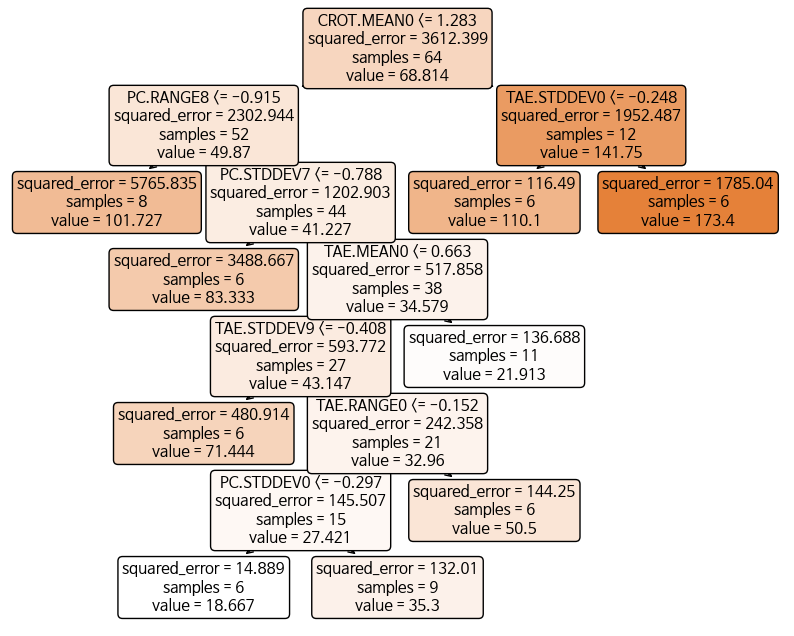

In [ ]:
from sklearn.tree import plot_tree
# 첫 번째 트리 시각화 (feature_names를 list로 변환)
plt.figure(figsize=(10, 8))
plot_tree(model_final.estimators_[0], filled=True, feature_names=list(X.columns), rounded=True)
plt.show()

# # 변수별 feature importance 출력
# feature_importances = model_final.feature_importances_
# print("Feature importances:")
# for name, importance in zip(X.columns, feature_importances):
#     print(f"{name}: {importance:.4f}")

<ipython-input-46-fb6674b278be>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp_top20["var_importance"], y=imp_top20["var_name"], palette=palette)


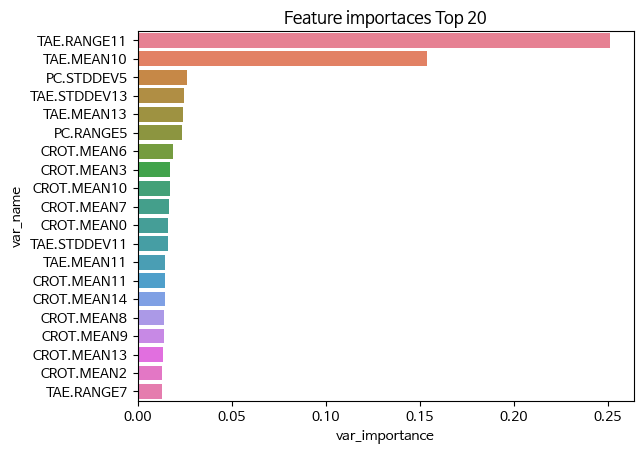

In [ ]:
#주요 변수 확인
import matplotlib.pyplot as plt
import seaborn as sns
var_imp = pd.DataFrame({'var_name':X.columns , 'var_importance': model_final.feature_importances_}) # 변수명과 해당 변수의 중요도 값을 데이터프레임 형태로 생성
imp_top20=var_imp.sort_values(by=['var_importance'],ascending=False)[:20] # 결과값 내림차순 정렬
palette = sns.color_palette("husl", len(imp_top20))

imp_top20.head(n=10) # 상위 10개변수만 출력
plt.figure
plt.title("Feature importaces Top 20")
sns.barplot(x=imp_top20["var_importance"], y=imp_top20["var_name"], palette=palette)
plt.show()

#변수 중요도 계산 과정 예시

In [ ]:
from sklearn.preprocessing import LabelEncoder
from matplotlib import font_manager, rc
import platform
# 한글 폰트 설정
if platform.system() == 'Windows':
    # Windows 운영체제
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

data= {
    '설비': ['A','B','A','B','B'],
    '온도': [18,20,22,19,17],
    '재료': ['C','D','C','D','C'],
    '제품 두께': [15,9, 14, 8, 9 ]
}
data = pd.DataFrame(data)

label_encoder = LabelEncoder()
data['설비'] = label_encoder.fit_transform(data['설비'])
data['재료'] = label_encoder.fit_transform(data['재료'])

X = data.drop(['제품 두께'], axis=1)
y = data['제품 두께']


In [ ]:
data

설비  온도  재료  제품 두께
0   0  18   0     15
1   1  20   1      9
2   0  22   0     14
3   1  19   1      8
4   1  17   0      9

In [ ]:
#한글 글꼴 깨짐 방지
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

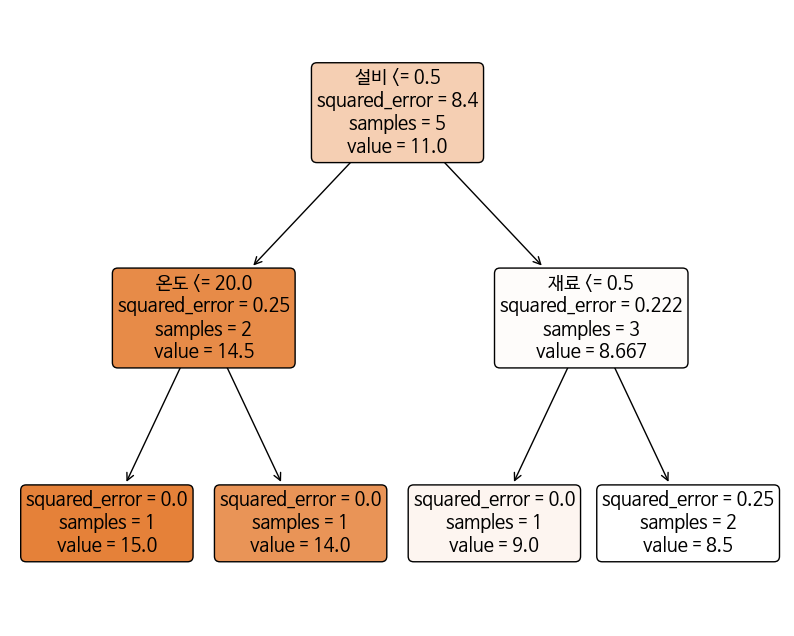

Feature importances:
설비: 0.9839
온도: 0.0120
재료: 0.0040


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')
# RandomForest 모델 생성 및 학습

# RandomForestRegressor 모델 생성 및 학습
rf_model = RandomForestRegressor(n_estimators=1, max_depth=2, max_leaf_nodes= 4 , bootstrap=False)
rf_model.fit(X, y)


# 첫 번째 트리 시각화 (feature_names를 list로 변환)
plt.figure(figsize=(10, 8))
plot_tree(rf_model.estimators_[0], filled=True, feature_names=list(X.columns), rounded=True)
plt.show()

# 변수별 feature importance 출력
feature_importances = rf_model.feature_importances_
print("Feature importances:")
for name, importance in zip(X.columns, feature_importances):
    print(f"{name}: {importance:.4f}")

In [ ]:
print('변수중요도_재료: ',(5/5*8.1667)/(5/5*8.1667+2/5*0.2500+3/5*0.0556) )
print('변수중요도_온도: ',(2/5*0.2500)/(5/5*8.1667+2/5*0.2500+3/5*0.0556) )
print('변수중요도_설비: ',(3/5*0.0556)/(5/5*8.1667+2/5*0.2500+3/5*0.0556) )

변수중요도_재료:  0.983932646270027
변수중요도_온도:  0.012048105676344508
변수중요도_설비:  0.004019248053628527


In [ ]:
# 노드별 정보 이득 계산 함수 정의
def compute_information_gain(tree, node_id=0):
    if tree.children_left[node_id] == tree.children_right[node_id]:  # 리프 노드
        return 0
    left_child = tree.children_left[node_id]
    right_child = tree.children_right[node_id]
    total_samples = tree.n_node_samples[node_id]
    weight_left = tree.n_node_samples[left_child] / total_samples
    weight_right = tree.n_node_samples[right_child] / total_samples
    impurity = tree.impurity[node_id]
    impurity_left = tree.impurity[left_child]
    impurity_right = tree.impurity[right_child]
    info_gain = impurity - (weight_left * impurity_left + weight_right * impurity_right)
    return info_gain

In [ ]:
# 첫 번째 트리 가져오기
first_tree = rf_model.estimators_[0].tree_

# 각 노드의 정보 이득 계산
info_gains = [compute_information_gain(first_tree, node) for node in range(first_tree.node_count)]

# 정보 이득 출력
print("Node-wise Information Gain for the First Tree:")
for node_id, gain in enumerate(info_gains):
    print(f"Node {node_id}: Information Gain = {gain:.4f}")

Node-wise Information Gain for the First Tree:
Node 0: Information Gain = 8.1667
Node 1: Information Gain = 0.2500
Node 2: Information Gain = 0.0556
Node 3: Information Gain = 0.0000
Node 4: Information Gain = 0.0000
Node 5: Information Gain = 0.0000
Node 6: Information Gain = 0.0000


In [ ]:
print('변수중요도_재료: ',(5/5*8.1667)/(5/5*8.1667+2/5*0.2500+3/5*0.0556) )
print('변수중요도_온도: ',(2/5*0.2500)/(5/5*8.1667+2/5*0.2500+3/5*0.0556) )
print('변수중요도_설비: ',(3/5*0.0556)/(5/5*8.1667+2/5*0.2500+3/5*0.0556) )

변수중요도_재료:  0.983932646270027
변수중요도_온도:  0.012048105676344508
변수중요도_설비:  0.004019248053628527
